In [1]:
pwd

'/Users/h_nagino/work/一般線形回帰/To_Nagino2/C-united_カフェドクリエ京都四条店'

In [3]:
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd
from datetime import datetime

t_start = datetime.strptime('2023/11/01 09:00', '%Y/%m/%d %H:%M').timestamp()
t_end   = datetime.strptime('2023/11/01 21:00', '%Y/%m/%d %H:%M').timestamp()
rssi    = 70
pos_data1 = pd.read_csv("POS_RAW_data/01306_20231101_01.csv")
pos_data2 = pd.read_csv("POS_RAW_data/01306_20231101_02.csv")
beacon_data = pd.read_csv("raw_data/10027BE3_20231101.csv")

pos_data1 = pos_data1[["商品コード", "商品名称（または券名称）", "単価", "数量", "合計金額"]]
pos_data2 = pos_data2[["商品コード", "商品名称（または券名称）", "単価", "数量", "合計金額"]]
pos_data  = pd.concat([pos_data1, pos_data2])

pos_data[["単価", "数量", "合計金額"]] = pos_data[["単価", "数量", "合計金額"]].map(lambda x: int(x))
pos_data = pos_data.groupby(["商品コード", "商品名称（または券名称）"]).sum()

pos_data["単価"] = pos_data["合計金額"] / pos_data["数量"]
pos_data["単価"] = pos_data["単価"].astype(int)

beacon_data.columns = ["No.", "mac-address", "distance", "rssi", "random", "timestamp"]
beacon_data = beacon_data[beacon_data["random"] == 1]
beacon_data = beacon_data[beacon_data["timestamp"] >= t_start]
beacon_data = beacon_data[beacon_data["timestamp"] <= t_end]
beacon_data = beacon_data[beacon_data["rssi"] < rssi]
beacon_data = beacon_data.drop_duplicates("mac-address")


print("総ビーコン数:", len(beacon_data))
print("総売上:", pos_data["合計金額"].sum())

総ビーコン数: 4799
総売上: 332190


In [4]:
import os
import pandas as pd
from datetime import datetime

def agg_data_for_unit():
    data_sets = pd.DataFrame()
    beacon_files = os.listdir('raw_data/')
    pos_files = os.listdir('POS_RAW_data/')

    beacon_files.sort()
    pos_files.sort()
    
    if beacon_files[0] == ".DS_Store":
        beacon_files.pop(0)

    if pos_files[0] == ".DS_Store":
        pos_files.pop(0)

    pos_files = list(map(lambda x: x[:14], pos_files))[::2]

    for beacon_file, pos_file in zip(beacon_files, pos_files):
        date_beacon = beacon_file[9:17]
        date_pos    = pos_file[6:14]

        if date_beacon != date_pos:
            continue
        else:
            date = date_beacon
        
        t_start = datetime.strptime(f'{date} 09:00', '%Y%m%d %H:%M').timestamp()
        t_end   = datetime.strptime(f'{date} 21:00', '%Y%m%d %H:%M').timestamp()
        rssi    = 70
        beacon_data = pd.read_csv(f"raw_data/{beacon_file}")
        pos_data1 = pd.read_csv(f"POS_RAW_data/{pos_file}_01.csv")
        pos_data2 = pd.read_csv(f"POS_RAW_data/{pos_file}_02.csv")

        pos_data1 = pos_data1[["商品コード", "商品名称（または券名称）", "単価", "数量", "合計金額"]]
        pos_data2 = pos_data2[["商品コード", "商品名称（または券名称）", "単価", "数量", "合計金額"]]
        pos_data  = pd.concat([pos_data1, pos_data2])

        pos_data[["単価", "数量", "合計金額"]] = pos_data[["単価", "数量", "合計金額"]].map(lambda x: int(x))
        pos_data = pos_data.groupby(["商品コード", "商品名称（または券名称）"]).sum()

        pos_data["単価"] = pos_data["合計金額"] / pos_data["数量"]
        pos_data["単価"] = pos_data["単価"].astype(int)

        beacon_data.columns = ["No.", "mac-address", "distance", "rssi", "random", "timestamp"]
        beacon_data = beacon_data[beacon_data["random"] == 1]
        beacon_data = beacon_data[beacon_data["timestamp"] >= t_start]
        beacon_data = beacon_data[beacon_data["timestamp"] <= t_end]
        beacon_data = beacon_data[beacon_data["rssi"] < rssi]
        beacon_data = beacon_data.drop_duplicates("mac-address")

        per_unit = pd.DataFrame(
            {
                "date":[date],
                "総ビーコン数": [len(beacon_data)],
                "総売上点数": [pos_data["数量"].sum()],
                "総売上": [pos_data["合計金額"].sum()],
            }
        )
        data_sets = pd.concat([data_sets, per_unit])

    return data_sets.reset_index(drop=True)

In [33]:
def calc_variance(real_y, mean_y):
    tmp_y = (real_y - mean_y) ** 2
    tmp_y = tmp_y.sum() / len(tmp_y)
    tmp_y = np.sqrt(tmp_y)
    return tmp_y

決定係数(train):0.510
決定係数(test):0.462

回帰係数
総ビーコン数    0.101516
dtype: float64
切片:297.103
標準偏差σ:184.759
3σ:554.277


/opt/homebrew/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


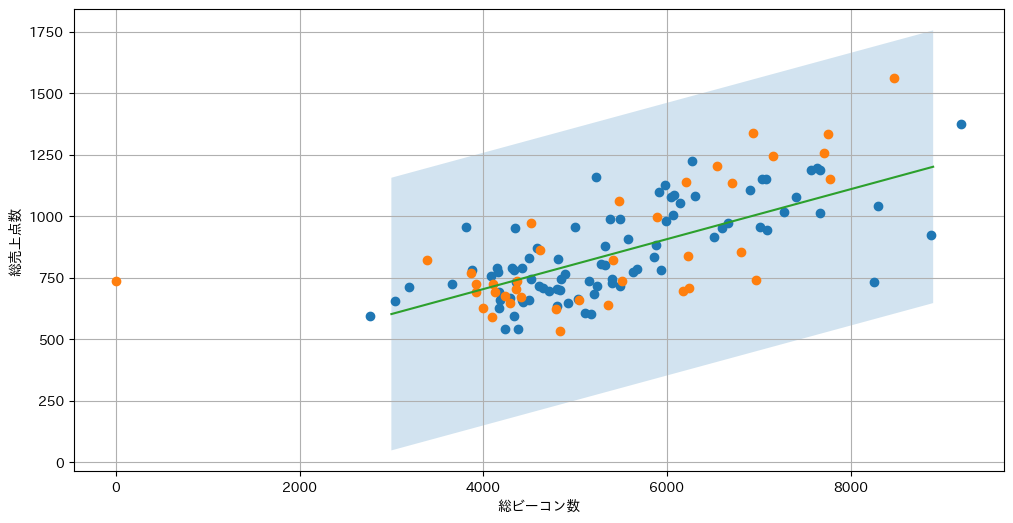

In [66]:
#標準化なし、線形モデル
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib as mlp
import matplotlib.pyplot as plt
import japanize_matplotlib

data_sets = agg_data_for_unit()

X = data_sets.drop(["date", "総売上点数", "総売上"], axis=1)
y = data_sets["総売上点数"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

print("決定係数(train):{:.3f}".format(model.score(X_train, y_train)))
print("決定係数(test):{:.3f}".format(model.score(X_test, y_test)))

print("\n回帰係数\n{}".format(pd.Series(model.coef_, index=X.columns)))
print("切片:{:.3f}".format(model.intercept_))

x = np.arange(3000, 9000, 100)
x = x.reshape(len(x), 1)

mean = model.predict(x)
var  = calc_variance(y_test, model.predict(X_test))

print("標準偏差σ:{:.3f}".format(var))
print("3σ:{:.3f}".format(3*var))

plt.figure(figsize=(12, 6))

plt.plot(X_train, y_train, "o")
plt.plot(X_test, y_test, "o")
plt.plot(x, mean, "-")
plt.fill_between(x.reshape(len(x)), mean - 3*var, mean + 3*var, alpha=0.2)
plt.xlabel("総ビーコン数")
plt.ylabel("総売上点数")
plt.grid(True)

決定係数(train):0.510
決定係数(test):0.462

回帰係数
総ビーコン数    132.967877
dtype: float64
切片:848.884
標準偏差σ:184.759
3σ:554.277


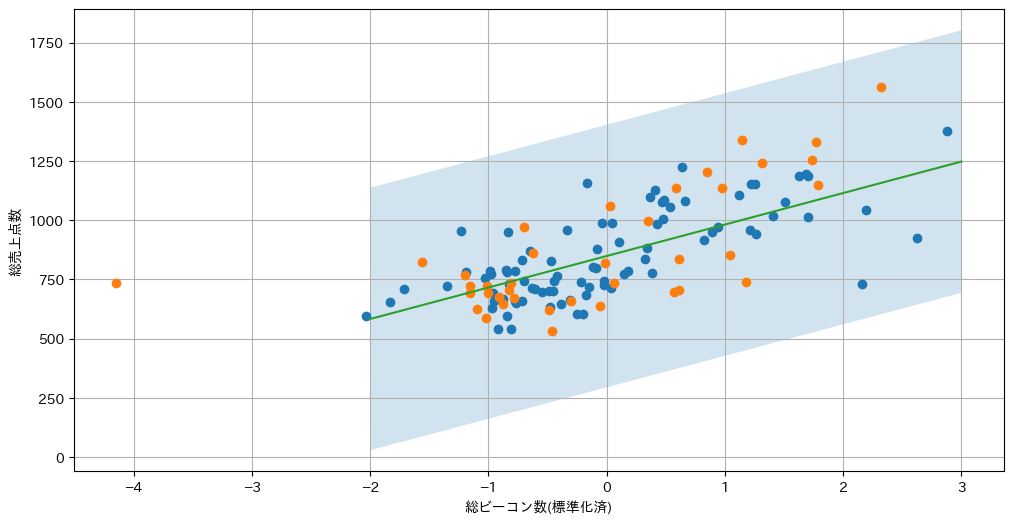

In [67]:
#標準化あり、線形モデル
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib as mlp
import matplotlib.pyplot as plt

data_sets = agg_data_for_unit()

X = data_sets.drop(["date", "総売上点数", "総売上"], axis=1)
y = data_sets["総売上点数"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std  = sc.transform(X_test)

model = LinearRegression()
model.fit(X_train_std, y_train)

print("決定係数(train):{:.3f}".format(model.score(X_train_std, y_train)))
print("決定係数(test):{:.3f}".format(model.score(X_test_std, y_test)))

print("\n回帰係数\n{}".format(pd.Series(model.coef_, index=X.columns)))
print("切片:{:.3f}".format(model.intercept_))

x = np.arange(-2, 3, 0.001)
x = x.reshape(len(x), 1)

mean = model.predict(x)
var  = calc_variance(y_test, model.predict(X_test_std))

print("標準偏差σ:{:.3f}".format(var))
print("3σ:{:.3f}".format(3*var))

plt.figure(figsize=(12, 6))

plt.plot(X_train_std, y_train, "o")
plt.plot(X_test_std, y_test, "o")
plt.plot(x, mean, "-")
plt.fill_between(x.reshape(len(x)), mean - 3*var, mean + 3*var, alpha=0.2)
plt.xlabel("総ビーコン数(標準化済)")
plt.ylabel("総売上点数")
plt.grid(True)

正解率(train):0.070
正解率(test):0.000


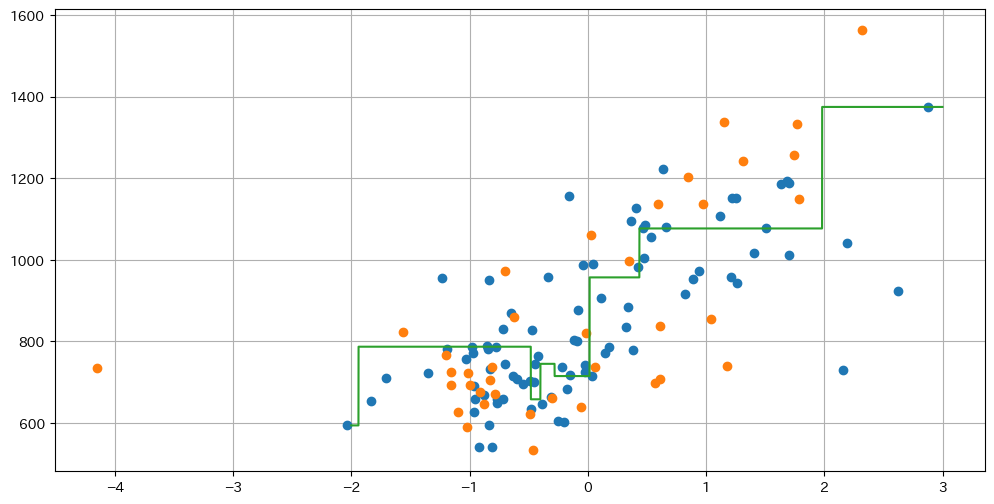

In [43]:
#標準化あり、ロジスティック回帰
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib as mlp
import matplotlib.pyplot as plt

data_sets = agg_data_for_unit()

X = data_sets.drop(["date", "総売上点数", "総売上"], axis=1)
y = data_sets["総売上点数"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std  = sc.transform(X_test)

model = LogisticRegression()
model.fit(X_train_std, y_train)

print("正解率(train):{:.3f}".format(model.score(X_train_std, y_train)))
print("正解率(test):{:.3f}".format(model.score(X_test_std, y_test)))

x = np.arange(-2, 3, 0.001)
x = x.reshape(len(x), 1)

plt.figure(figsize=(12, 6))

plt.plot(X_train_std, y_train, "o")
plt.plot(X_test_std, y_test, "o")
plt.plot(x, model.predict(x), "-")
plt.grid(True)

正解率(train):0.505
正解率(test):0.506
標準偏差σ:23.831
3σ:71.492


/opt/homebrew/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PoissonRegressor was fitted with feature names
  warnings.warn(


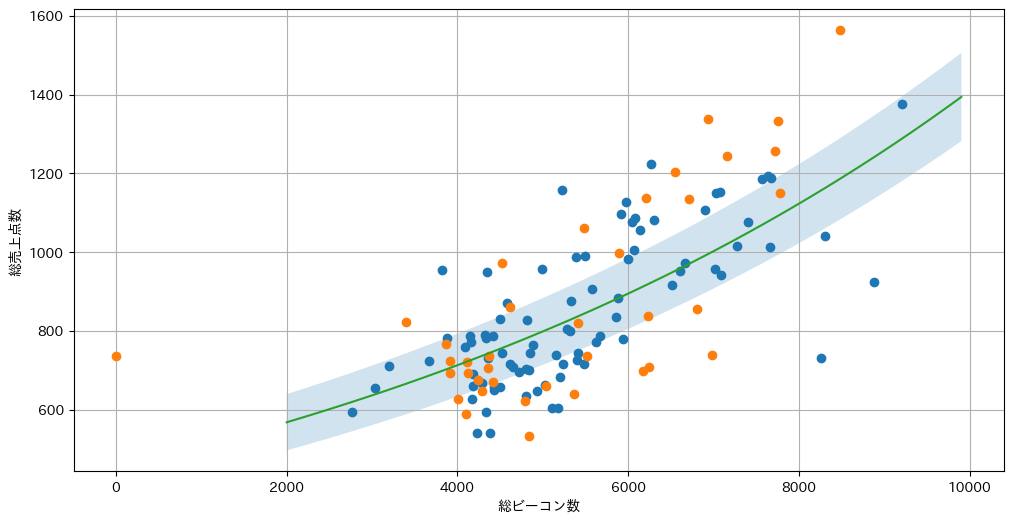

In [70]:
#標準化なし、ポアソン回帰
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib as mlp
import matplotlib.pyplot as plt

data_sets = agg_data_for_unit()

X = data_sets.drop(["date", "総売上点数", "総売上"], axis=1)
y = data_sets["総売上点数"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#sc = StandardScaler()
#sc.fit(X_train)
#X_train_std = sc.transform(X_train)
#X_test_std  = sc.transform(X_test)

model = PoissonRegressor(solver="newton-cholesky")
model.fit(X_train, y_train)

print("正解率(train):{:.3f}".format(model.score(X_train, y_train)))
print("正解率(test):{:.3f}".format(model.score(X_test, y_test)))

x = np.arange(2000, 10000, 100)
x = x.reshape(len(x), 1)

mean = model.predict(x)
var  = np.sqrt(mean)

print("標準偏差σ:{:.3f}".format(var[0]))
print("3σ:{:.3f}".format(3*var[0]))

plt.figure(figsize=(12, 6))

plt.plot(X_train, y_train, "o")
plt.plot(X_test, y_test, "o")
plt.plot(x, mean, "-")
plt.fill_between(x.reshape(len(x)), mean - 3*var, mean + 3*var, alpha=0.2)
plt.xlabel("総ビーコン数")
plt.ylabel("総売上点数")
plt.grid(True)

正解率(train):0.673
正解率(test):0.479


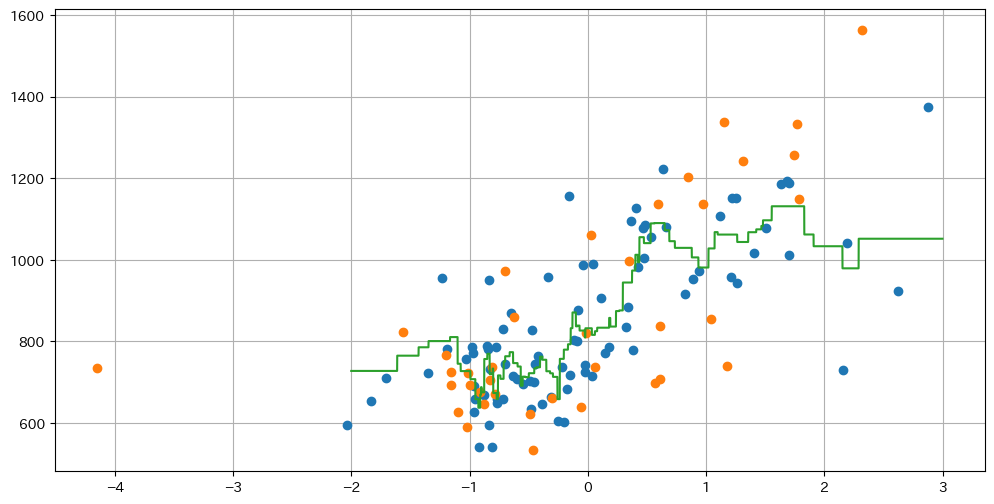

In [45]:
#標準化あり、k-NN回帰(k近傍法回帰)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib as mlp
import matplotlib.pyplot as plt

data_sets = agg_data_for_unit()

X = data_sets.drop(["date", "総売上点数", "総売上"], axis=1)
y = data_sets["総売上点数"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std  = sc.transform(X_test)

model = KNeighborsRegressor()
model.fit(X_train_std, y_train)

print("正解率(train):{:.3f}".format(model.score(X_train_std, y_train)))
print("正解率(test):{:.3f}".format(model.score(X_test_std, y_test)))

x = np.arange(-2, 3, 0.001)
x = x.reshape(len(x), 1)

plt.figure(figsize=(12, 6))

plt.plot(X_train_std, y_train, "o")
plt.plot(X_test_std, y_test, "o")
plt.plot(x, model.predict(x), "-")
plt.grid(True)